In [2]:
# Imports
import numpy as np
from ypstruct import structure
import random
import matplotlib.pyplot as plt

#### Problem representation

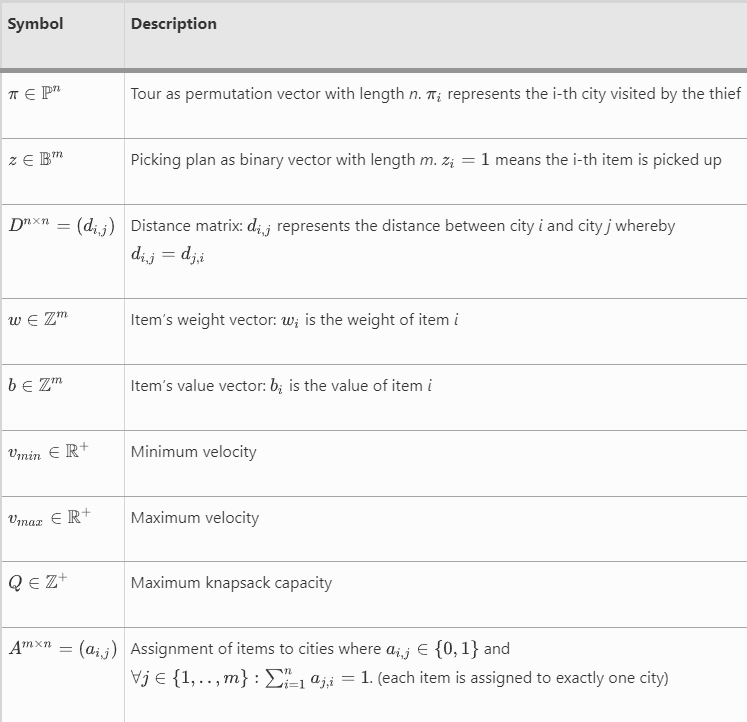

Code Example:

```python
item_values = np.array([30, 34, 40, 25]) # in order, so item 0 has a value of 30, item 1 has a value of 34, etc...
item_weights = np.array([25, 30, 40, 21]) # same as above but for weights
D = distance_matrix = np.array(
    [
    [0, 4, 9, 3],
    [4, 0, 5, 5],
    [9, 5, 0, 4],
    [3, 5, 4, 0]
    ]
)
```
For example, the following matrix says that item 0 is in city 0, item 1 in city 1, item 2 in city 2, item 3 in city 3. The rows correspond to the items and the columns to the cities.
```python
A = item_to_city_mapping = np.array(
    [
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
    ]
)
```
Example candidate solution:
```python
candidate_solution = structure()
candidate_solution.tour = np.array([1, 3, 2, 4]) # 4 cities
candidate_solution.knapsack = np.array([0, 1, 0, 1]) # 4 items
candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping, item_weights)
candidate_solution.knapsack_cost = knapsack_cost(candidate_solution, item_values)
```
Can access attributes via ```candidate_solution.tour``` and add an attribute with any name via ```candidate_solution.name = whatever```

In [ ]:
def make_distance_matrix(file_path): # Kaiyuan
    distance_matrix = None
    """
    Make a distance matrix based off the data contained in the .txt files, containing data about distances between cities and
    data about the items and which city they are in.

    Parameters:
    - file_path (str): path to the file containing the data

    Returns:
    - np.ndarray: The distance matrix

    Example of distance matrix format: 
    distance_matrix = np.array(
        [
        [0, 4, 9, 3],
        [4, 0, 5, 5],
        [9, 5, 0, 4],
        [3, 5, 4, 0]
        ]
    )

    
    """
    return distance_matrix

In [ ]:
def make_item_matrix(file_path): # Kaiyuan
    item_to_city_mapping_matrix = None
    """
    Make an item to city matrix based off the data contained in the .txt files, containing data about distances between cities and
    data about the items and which city they are in.

    Parameters:
    - file_path (str): path to the file containing the data

    Returns:
    - np.ndarray: The item to city mapping matrix
    
    Example of matrix format:
    item_to_city_mapping_matrix = np.array(
        [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
        ]
    )
    
    """

    return item_to_city_mapping_matrix

In [ ]:
def random_tour(distance_matrix: np.ndarray) -> np.ndarray: 
    
    """
    Generate a random tour by shuffling the indices of cities based on a given distance matrix.

    Parameters:
    - distance_matrix (numpy.ndarray): A square matrix representing the distances between cities.

    Returns:
    - numpy.ndarray: A list containing a random sequence of indices representing a tour.

    The function shuffles the indices of cities to create a random tour for the Travelling Thief Problem
    (TTP) based on the given distance matrix. Each index corresponds to a city, and the resulting sequence 
    represents the order in which the cities are visited in the tour.
    """

    return np.array(random.sample(list(range(distance_matrix.shape[0])), k = distance_matrix.shape[0]))

In [1]:
def find_min_indices_in_row(matrix: np.ndarray, row_index: int) -> list: 

    """
    Find the indices of minimum values in a specific row of a NumPy matrix.

    Parameters:
    - matrix (numpy.ndarray): The input matrix.
    - row_index (int): The index of the row in which to find the minimum values.

    Returns:
    - list: A list containing the indices of the minimum values in the specified row.

    If there's a single minimum value in the row, the function returns a list containing
    only its column index in the specified row. If there are duplicates (multiple minimum values),
    the function returns a list containing all occurrences of the minimum values within the row.
    """

    row = matrix[row_index, :]
    min_value = np.min(row)
    min_indices = np.where(row == min_value)

    if len(min_indices[0]) == 1:
        # If there's a single minimum value, return only its index in the specified row
        return [min_indices[0][0]]
    else:
        # If there are duplicates, return all occurrences within the specified row
        return [col_index for col_index in min_indices[0]]


In [ ]:
def nearest_neighbour(distance_matrix: np.ndarray) -> np.ndarray:

    """
    Apply the nearest neighbour heuristics algorithm to find an initial route for the Traveling Thief Problem (TTP).

    Parameters:
    - distance_matrix (numpy.ndarray): A square matrix representing the distances between cities.

    Returns:
    - numpy.ndarray: A list containing the sequence of cities representing the initial route based on
      the nearest neighbor algorithm.

    The function starts from a randomly chosen city and iteratively selects the nearest unvisited
    city until all cities are visited, forming an initial route for the TTP.
    """


    dist_matrix = distance_matrix.copy()
    num_cities = distance_matrix.shape[0]
    tour = random.sample(list(range(num_cities)), k = 1)
    dist_matrix[:, tour[0]] = np.inf

    for _ in range(1, num_cities):
        current_city = tour[-1]
        next_city = random.sample(find_min_indices_in_row(dist_matrix, current_city), k = 1)[0]
        tour.append(next_city)
        dist_matrix[:, next_city] = np.inf
    
    return np.array(tour)



In [ ]:
def tour_length(tour: np.ndarray, distance_matrix: np.ndarray) -> float:
    """
    Calculate the total length of a tour based on a given distance matrix.

    Parameters:
    - tour (numpy.ndarray): An array containing the sequence of cities visited in the tour.
    - distance_matrix (numpy.ndarray): A matrix representing the distances between cities.

    Returns:
    - float: The total length of the tour, considering the distances between consecutive cities.

    The function calculates the total length of the tour by summing the distances between consecutive
    cities in the given tour sequence. Additionally, it includes the length of returning from the last
    city in the tour back to the starting city to complete the tour.
    """

    # length of going from last city in the chromosme back to the starting chromosome
    return_to_start_length = distance_matrix[len(distance_matrix)-1][tour[0]]
    # calculate the length of the rest of the tour
    travel_length = 0
    for i in range(0, len(distance_matrix)-1, 1):
        travel_length += distance_matrix[tour[i]][tour[i+1]]

    return travel_length + return_to_start_length

In [ ]:
def nearest_neighbour_2opt(distance_matrix: np.ndarray) -> np.ndarray:

    """
    Apply the 2opt nearest neighbour heuristics algorithm to find an initial route for the Traveling Thief Problem (TTP).

    Parameters:
    - distance_matrix (numpy.ndarray): A square matrix representing the distances between cities.

    Returns:
    - numpy.ndarray: A list containing the sequence of cities representing the initial route based on
      the 2opt nearest neighbor algorithm.

    The function starts from a randomly chosen city and iteratively selects the nearest unvisited
    city until all cities are visited, forming an initial route for the TTP. Once this has been done it randomly selects to nodes to swap
    until a swap operation is found which is better than the initial packing plan.
    """


    tour = nearest_neighbour(distance_matrix=distance_matrix)
    number_of_cities = distance_matrix.shape[0]
    max_2opt_moves = (number_of_cities) * (number_of_cities - 1) / 2
    made_moves = []
    length = tour_length(tour, distance_matrix)
    better = False
    i = 0 

    while not better and i < max_2opt_moves:
        i += 1
        idx = range(len(tour))
        made_move = False
        i1, i2 = (None, None)
        while not made_move:
            i1_test, i2_test = random.sample(idx, 2)
            if (i1_test, i2_test) in made_moves or (i2_test, i1_test) in made_moves:
                continue
            else:
                i1, i2 = i1_test, i2_test
                made_move = True
        made_moves.append((i1, i2))
        made_moves.append((i2, i1))
        new_tour = tour.copy()
        new_tour[i1], new_tour[i2] = new_tour[i2], new_tour[i1]
        if tour_length(new_tour, distance_matrix) < length:
            better = True
            tour = new_tour
    return np.array(tour)

In [ ]:
def pack_one(init_pop: list, item_to_city_mapping: np.ndarray) -> list:
    number_of_items = item_to_city_mapping.shape[0]
    for candidate_solution in init_pop:
        packing_plan = np.zeros(number_of_items)
        chosen_item = random.sample(list(range(number_of_items)), k = 1)
        packing_plan[chosen_item] = 1
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [ ]:
def pack_random(init_pop: list, item_to_city_mapping: np.ndarray) -> list:
    number_of_items = item_to_city_mapping.shape[0]
    for candidate_solution in init_pop:
        packing_plan = np.array([random.choice(list(range(2))) for _ in range(number_of_items)])
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [ ]:
value_to_weight_ratio = item_values / item_weights
value_to_weight_ratio_dict = {}
for i in range(len(value_to_weight_ratio)):
    value_to_weight_ratio_dict[i] = value_to_weight_ratio[i]
sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))
sorted_value_to_weight_ratio_dict

In [ ]:
def pack_optimal(init_pop: list, item_to_city_mapping: np.ndarray, Q: float, value_to_weight_ratio_dict: dict, item_weights: list) -> list:
    number_of_items = item_to_city_mapping.shape[0]
    
    sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))

    for candidate_solution in init_pop:
        Q_prime = np.random.randint(low = 0, high = Q, size = 1)
        packing_plan = np.zeros(number_of_items)
        weight  = 0
        for i in range(number_of_items):
            if weight + item_weights[list(sorted_value_to_weight_ratio_dict.keys())[i]] < Q_prime:
                packing_plan[list(sorted_value_to_weight_ratio_dict.keys())[i]] = 1
                weight += item_weights[list(sorted_value_to_weight_ratio_dict.keys())[i]]
        candidate_solution.packing_plan = np.array(packing_plan)
    return init_pop

In [ ]:
def generate_initial_population(pop_size, distance_matrix, item_to_city_mapping_matrix, tour_init_method, pack_init_method, Q = None, value_to_weight_ratio_dict = None, item_weights = None): # Jack

    init_pop = []

    if tour_init_method == "random":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = random_tour(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)
    elif tour_init_method == "nearest_neighbour":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = nearest_neighbour(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)
    elif tour_init_method == "2opt_nearest_neighbour":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = nearest_neighbour_2opt(distance_matrix=distance_matrix)
            init_pop.append(candidate_solution)

    if pack_init_method == "random":
        pack_random(init_pop, item_to_city_mapping_matrix)
    elif pack_init_method == "pack_one":
        pack_one(init_pop, item_to_city_mapping_matrix)
    elif pack_init_method == "pack_optimal":
        pack_optimal(init_pop, item_to_city_mapping_matrix, Q, value_to_weight_ratio_dict, item_weights)

    return init_pop

Cost function for the knapsack, as given by:
$$
  \sum^m_{j = 1} z_j * b_j
$$
where $z_j$ is the a binary vector where each index corresponds to an item and is 0 if the item is not picked and 1 if it is and $b_j$ is the values vector.

In [1]:
def knapsack_cost(candidate_solution, item_values):
    
    """
    Calculate the total cost of a candidate solution in a knapsack problem.

    Parameters:
    - candidate_solution (numpy.ndarray): A candidate_solution represented as a structure from the ypstruct library with a 
    knapsack attribute, tour attribute, knapsack_cost attribute and tour_cost attribute.
    - item_values (numpy.ndarray): An array of values corresponding to each item
      in the knapsack. The first value corresponds to the value of the first item, the second corresponds to the value for the second, 
      etc...

    Returns:
    - float: The total cost of the candidate solution, computed as the sum of
      selected item values in the knapsack.
    """

    return np.sum(candidate_solution.knapsack * item_values)

Cost function for the tour, taking into account velocity, as given by:
$$
    f(\pi, z) = \frac{d_{\pi_1, \pi_{n}} * R}{v(w(\pi_{n}))} + \sum^{n-1}_{i = 1} \frac{d_{\pi_i, \pi_{i+1}} * R}{v(w(\pi_{i}))}
$$ 
where 
$$
    w(\pi_i) = \sum^{i}_{k=1}\sum^{m}_{j=1} z_j * b_j * a_{j, \pi_i}
$$ 

and 
$$
    v(q) = v_{max} - \frac{q}{Q} * (v_{max} - v_{min})
$$ 

where $d_{\pi_i, \pi_{i+1}}$ is the distance between city $i$ and $i+1$, obtained from the distance matrix $d$ and $a$ is the item mapping matrix and R is the renting ratio

In [1]:
def tour_cost(candidate_solution, distance_matrix, item_to_city_mapping, item_weights, vmax, vmin, Q, renting_ratio):

    """
    Calculate the total completion time for a thief's tour in a Travelling Thief Problem (TTP).

    Parameters:
    - candidate_solution (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
    The structure also includes other attributes like knapsack_cost and tour_cost.

    - distance_matrix (numpy.ndarray): A matrix containing the distances between cities.
    - item_to_city_mapping (list): A matrix mapping items to cities.
    - item_weights (numpy.ndarray): An array containing the weights of the items.
    - vmax (float): Maximum velocity of the thief.
    - vmin (float): Minimum velocity of the thief.
    - Q (float): Capacity constraint of the thief's knapsack.

    Returns:
    - float: The total completion time for the thief's tour, considering knapsack capacity,
      item weights, and travel distances between cities.
    """


    tour = candidate_solution.tour
    
    # calculate the weight picked up at each city
    weight_at_city_i = []
    for j in range(0, len(tour)):
        item_in_city = np.array([col[tour[j]-1] for col in item_to_city_mapping])
        weight_at_city_i.append(sum(item_in_city * candidate_solution.knapsack * item_weights))
    # calculate the total weight that the thief has when leaving each city using the cumulative sum 
    weight_at_city_i = np.array(np.cumsum(weight_at_city_i))

    # calculate the velocity of the thief when leaving each city
    velocity_at_city_i = vmax - weight_at_city_i / Q * (vmax - vmin)

    # retrieve the distance between the cities 
    distance_between_cities = []
    for i in range(0, len(tour)-1):
        distance_between_cities.append(distance_matrix[tour[i]-1][tour[i+1]-1])
    distance_between_cities.append(distance_matrix[tour[0]-1][tour[-1]-1])
    distance_matrix = np.array(distance_between_cities)
    
    # return the total completion time
    return np.sum(distance_between_cities / velocity_at_city_i) * renting_ratio

In [ ]:
def evaluate_candidate_solution_cost(candidate_solution, distance_matrix, item_to_city_mapping_matrix, item_weights, item_values, renting_ratio):
    candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_matrix, item_weights, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

In [ ]:
def evaluate_init_pop_cost(init_pop, distance_matrix, item_to_city_mapping_matrix, item_weights, item_values, renting_ratio):
    for candidate_solution in init_pop:
        candidate_solution.tour_cost = tour_cost(candidate_solution, distance_matrix, item_to_city_mapping_matrix, item_weights, renting_ratio)
        candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return init_pop

Each individual gets a rank based on its level of domination

 Then both the populations are combined and classified using non-dominated sorting. After the completion of non-dominated sorting, filling of new population starts with the assignment of rank 1 for the best non-dominated front. This continues for successive fronts with the assignment of ranks.

  The fast sort algorithm [3] is described as below for each.

• for each individual p in main population P do the following

    – Initialize Sp = ∅. This set would contain all the individuals that is
    being dominated by p.

    – Initialize np = 0. This would be the number of individuals that dominate p.

    – for each individual q in P

        ∗ if p dominated q then

            · add q to the set Sp i.e. Sp = Sp ∪ {q}

        ∗ else if q dominates p then

            · increment the domination counter for p i.e. np = np + 1

    – if np = 0 i.e. no individuals dominate p then p belongs to the first
      front; Set rank of individual p to one i.e prank = 1. Update the first
      front set by adding p to front one i.e F1 = F1 ∪ {p}

• This is carried out for all the individuals in main population P.

• Initialize the front counter to one. i = 1

• following is carried out while the i
th front is nonempty i.e. Fi 6= ∅

    – Q = ∅. The set for storing the individuals for (i + 1)th front.

    – for each individual p in front Fi

        ∗ for each individual q in Sp (Sp is the set of individuals dominated
        by p)

            · nq = nq −1, decrement the domination count for individual
            q.

            · if nq = 0 then none of the individuals in the subsequent
            fronts would dominate q. Hence set qrank = i + 1. Update
            the set Q with individual q i.e. Q = Q ∪ q.

    – Increment the front counter by one.
    
    – Now the set Q is the next front and hence Fi = Q.

    https://web.njit.edu/~horacio/Math451H/download/Seshadri_NSGA-II.pdf

In [ ]:
def get_ranks(population): # Ursula
    pass # return (rank, structure()) or candidate solution object as represented above with an additional "rank" attribute
         # doesn't need to return anything if only adding "rank" attribute to candidate solution.
         # Probs easier for later functions if just add crowding_distance attribute to candidate solution

The crowding distance is used as a density estimation in the objective space.

For each front Fi, n is the number of individuals.

– initialize the distance to be zero for all the individuals i.e. Fi(dj ) = 0,
where j corresponds to the jth individual in front Fi.

– for each objective function m

    ∗ Sort the individuals in front Fi based on objective m i.e. I = sort(Fi, m)

    ∗ Assign infinite distance to boundary values for each individual in Fi

    i.e. I(d1) = ∞ and I(dn) = ∞

    ∗ for k = 2 to (n − 1)

        · I(d_k) = I(dk) + I(k + 1).m − I(k − 1).m/fmaxm − fminm
        
        · I(k).m is the value of the mth objective function of the kth individual in I


https://www.sciencedirect.com/topics/computer-science/crowding-distance

In [ ]:
def get_crowding_distance(): # Ursula
    pass # return (crowding_distance, structure()) or 
         # candidate solution object as represented above with an additional "crowding_distance" attribute.
         # doesn't need to return anything if only adding "crowding_distance" attribute to candidate solution.
         # Probs easier for later functions if just add crowding_distance attribute to candidate solution

In [ ]:
def tournament_selection(population): # Swaroop
    
    """
    Performs NSGA-II style tournament selection.

    Parameters:
    - population (list): list of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    
    Randomly select 2 candidate solutions from the population (without replacement) compare first their rank (return) the one with the lowest 
    rank. If they have the same rank, return solution with greater crowding distance.

    Return: 
    ypstruct.Struct: candidate solution represented in the same way as the candidate solutions in the population
    """

    pass

In [ ]:
def OX1_tour_crossover(parent1, parent2): # Kanchan

    """
    Implement single-point ordered crossover (OX1 Crossover) on the tours of the parents selected by tournament selection in order to 
    produce the children.

    Parameters:
    - parent1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - parent2 (ypstruct.Struct): same as parent1

    Perform single-point ordered crossover on the tours contained in the parent structures.

    Return:
    ypstruct.Struct: the first child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over tours.
    ypstruct.Struct: the second child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over tours.


    """
    
    pass

In [ ]:
def packing_plan_crossover(parent1, parent2, crossover_type): # Jack

    """
    Implement single point or two point crossover on the packing plans of the parents selected by tournament selection in order to 
    produce the children.

    Parameters:
    - parent1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - parent2 (ypstruct.Struct): same as parent1
    - crossover_type (str): defines the crossover type to be used. Can be either "single_point" or "two_point".

    Implement single point or two point crossover on the packing plans of the parents selected by tournament selection in order to 
    produce the children.

    Return:
    ypstruct.Struct: the first child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over packing plans.
    ypstruct.Struct: the second child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over placking plans.


    """


    pass

In [ ]:
def derive_tour_from_packing_plan(child1, child2):
    pass

In [ ]:
def derive_packing_plan_from_tour(child1, child2): 
    pass

In [ ]:
def tour_mutation(child1, child2, mutation_type): # Kaiyuan
    
    """
    Implement single swap mutation or inversion mutation on the tours of the children.

    Parameters:
    - child1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - child2 (ypstruct.Struct): same as parent1
    - mutation_type (str): defines the mutation type to be used. Can be either "single_swap" or "inversion".

    Implement single swap mutation or inversion mutation on the tours of the children produced by the crossover operation.

    Return:
    ypstruct.Struct: the first mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated tour.
    ypstruct.Struct: the second mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated tour.


    """
    
    pass

In [ ]:
def packing_plan_mutation(child1, child2, mutation_percentage): # Nafees

    """
    Implement bit flip mutation on the packing plans of the children.

    Parameters:
    - child1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - knapsack_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - child2 (ypstruct.Struct): same as parent1
    - mutation_percentage (float): defines the percentage of bits to be flipped

    Implement bit flip mutation on the packing plans of the children produced by the crossover operation. Can define the percentage of bits
    to be flipped

    Return:
    ypstruct.Struct: the first mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated packing plan.
    ypstruct.Struct: the second mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated packing plan.


    """

    pass

In [ ]:
def repair_operator(candidate_solution): #
    pass

In [ ]:
def replacement(): #
    pass

In [ ]:
def get_best_solutions(): # Nafees
    pass # return all non-dominated solutions (rank 1)